<a href="https://www.kaggle.com/code/malekmessaoudi/word-embedding-french-sentiment-analysis?scriptVersionId=265348762" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/french-twitter-sentiment-analysis/french_tweets.csv


In [2]:
!pip install gradio

In [3]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import gradio as gr

In [4]:
data = pd.read_csv('/kaggle/input/french-twitter-sentiment-analysis/french_tweets.csv')

data.head()

,label,text
0,0,"- Awww, c'est un bummer. Tu devrais avoir davi..."
1,0,Est contrarié qu'il ne puisse pas mettre à jou...
2,0,J'ai plongé plusieurs fois pour la balle. A ré...
3,0,Tout mon corps a des démangeaisons et comme si...
4,0,"Non, il ne se comporte pas du tout. je suis en..."


In [5]:
print(data.info())
print(data['label'].value_counts()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526724 entries, 0 to 1526723
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   label   1526724 non-null  int64 
 1   text    1526724 non-null  object
dtypes: int64(1), object(1)
memory usage: 23.3+ MB
None
label
0    771604
1    755120
Name: count, dtype: int64


In [6]:
# Limiter à 500 000 tweets par classe
data_balanced = data.groupby('label').apply(lambda x: x.sample(n=500000, random_state=42)).reset_index(drop=True)

print(data_balanced['label'].value_counts())

label
0    500000
1    500000
Name: count, dtype: int64


/tmp/ipykernel_19/2106389185.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_balanced = data.groupby('label').apply(lambda x: x.sample(n=500000, random_state=42)).reset_index(drop=True)


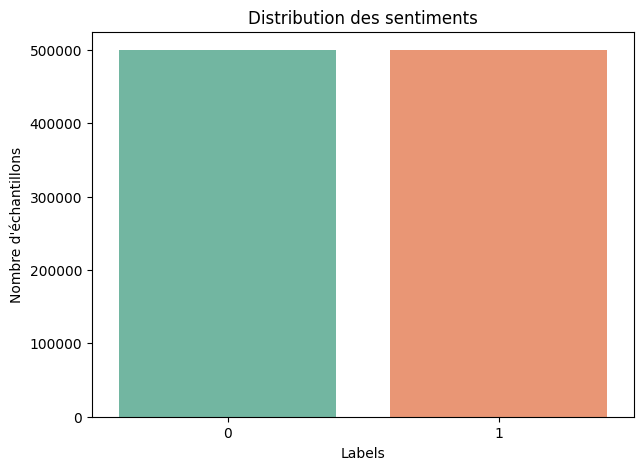

In [7]:
# Visualisation avec seaborn
plt.figure(figsize=(7,5))
sns.countplot(x='label', data=data_balanced, palette='Set2')
plt.title("Distribution des sentiments")
plt.xlabel("Labels")
plt.ylabel("Nombre d'échantillons")
plt.show()

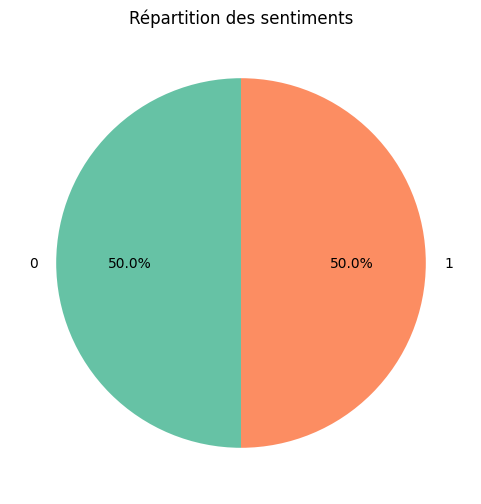

In [8]:
# Diagramme circulaire
plt.figure(figsize=(6,6))
data_balanced['label'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2"))
plt.title("Répartition des sentiments")
plt.ylabel("")  # Pour enlever le label 'label'
plt.show()

In [9]:
# Cellule pédagogique unique — nettoyage de texte pas à pas (exécution + explications)
import re
import string
import nltk
from nltk.corpus import stopwords
import pandas as pd

# --- Préparation des stopwords ---
# Téléchargement (silencieux) si nécessaire
nltk.download('stopwords', quiet=True)
try:
    stop_words = set(stopwords.words('french'))
except LookupError:
    # Si téléchargement échoue, afficher message clair
    print("Erreur: la ressource 'stopwords' de NLTK est introuvable.")
    print("Exécutez: nltk.download('stopwords') puis relancez la cellule.")
    raise

In [10]:
# Petite explication (affichée)
print("QU'EST-CE QU'UN STOPWORD ?")
print("-" * 60)
print("Un *stopword* est un mot très fréquent mais peu informatif (ex : 'et', 'la', 'de', 'un').")
print("On les retire souvent avant d'entraîner un modèle NLP pour se concentrer sur les mots porteurs de sens.")
print(f"Nombre de stopwords (français) chargés : {len(stop_words)}")
print("Exemples de stopwords :", sorted(list(stop_words))[:30])
print("\n" + "="*80 + "\n")

QU'EST-CE QU'UN STOPWORD ?
------------------------------------------------------------
Un *stopword* est un mot très fréquent mais peu informatif (ex : 'et', 'la', 'de', 'un').
On les retire souvent avant d'entraîner un modèle NLP pour se concentrer sur les mots porteurs de sens.
Nombre de stopwords (français) chargés : 157
Exemples de stopwords : ['ai', 'aie', 'aient', 'aies', 'ait', 'as', 'au', 'aura', 'aurai', 'auraient', 'aurais', 'aurait', 'auras', 'aurez', 'auriez', 'aurions', 'aurons', 'auront', 'aux', 'avaient', 'avais', 'avait', 'avec', 'avez', 'aviez', 'avions', 'avons', 'ayant', 'ayante', 'ayantes']




In [11]:
# --- Exemple de texte brut (typique d'un tweet / message) ---
exemple = "Bonjour à tous !!! Je vais vous partager un lien utile : https://exemple.com @Pierre123 😃 J'ai 2 chats et 1 chien."
print("Texte original :")
print(exemple)
print("\n" + "-"*80 + "\n")

# --- Étape 1 : suppression des mentions (@utilisateur) ---
step1 = re.sub(r'@\w+', '', exemple)
print("Étape 1 — Suppression des mentions (@utilisateur) :")
print(step1)
print("\n" + "-"*80 + "\n")

# --- Étape 2 : suppression des URLs ---
step2 = re.sub(r'http\S+|www\S+|https\S+', '', step1, flags=re.MULTILINE)
print("Étape 2 — Suppression des URLs :")
print(step2)
print("\n" + "-"*80 + "\n")

# --- Étape 3 : suppression de la ponctuation ASCII (string.punctuation) ---
step3 = step2.translate(str.maketrans('', '', string.punctuation))
print("Étape 3 — Suppression de la ponctuation (ASCII) :")
print(step3)
print("\nRemarque : certains signes unicode (ex: guillemets typographiques) peuvent rester.")
print("\n" + "-"*80 + "\n")

# --- Étape 4 : suppression des chiffres ---
step4 = re.sub(r'\d+', '', step3)
print("Étape 4 — Suppression des chiffres :")
print(step4)
print("\n" + "-"*80 + "\n")

# --- Étape 5 : conversion en minuscules ---
step5 = step4.lower()
print("Étape 5 — Conversion en minuscules :")
print(step5)
print("\n" + "-"*80 + "\n")

# --- Étape 6 : suppression des stopwords ---
tokens = step5.split()
kept_tokens = [w for w in tokens if w not in stop_words]
step6 = " ".join(kept_tokens)
print("Étape 6 — Suppression des stopwords :")
print("Tokens avant suppression :", tokens)
print("Tokens après suppression  :", kept_tokens)
print("\nTexte final nettoyé :")
print(step6)
print("\n" + "="*80 + "\n")

Texte original :
Bonjour à tous !!! Je vais vous partager un lien utile : https://exemple.com @Pierre123 😃 J'ai 2 chats et 1 chien.

--------------------------------------------------------------------------------

Étape 1 — Suppression des mentions (@utilisateur) :
Bonjour à tous !!! Je vais vous partager un lien utile : https://exemple.com  😃 J'ai 2 chats et 1 chien.

--------------------------------------------------------------------------------

Étape 2 — Suppression des URLs :
Bonjour à tous !!! Je vais vous partager un lien utile :   😃 J'ai 2 chats et 1 chien.

--------------------------------------------------------------------------------

Étape 3 — Suppression de la ponctuation (ASCII) :
Bonjour à tous  Je vais vous partager un lien utile    😃 Jai 2 chats et 1 chien

Remarque : certains signes unicode (ex: guillemets typographiques) peuvent rester.

--------------------------------------------------------------------------------

Étape 4 — Suppression des chiffres :
Bonjour à

In [12]:
# --- Fonction utilitaire finale (même pipeline, sans prints) ---
def clean_text(text, stop_words=stop_words):
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    text = " ".join([w for w in text.split() if w not in stop_words])
    return text

In [13]:
# --- Application au DataFrame 'data' si présent, sinon démonstration sur un petit DataFrame ---
if 'data' in globals() and isinstance(data_balanced, pd.DataFrame) and 'text' in data_balanced.columns:
    # On n'écrase pas 'data' si l'utilisateur l'a déjà défini — on ajoute juste la colonne
    data_balanced['cleaned_text'] = data_balanced['text'].apply(clean_text)
    print("Application faite sur votre DataFrame 'data'. Aperçu (avant / après) :")
    display(data_balanced[['text', 'cleaned_text']].head(5))
else:
    demo = pd.DataFrame({
        'text': [
            exemple,
            "Super offre !! Visitez www.offre.com maintenant. @Store 50% OFF!!",
            "Demain 10h réunion avec le Dr. Dupont - confirmez svp."
        ]
    })
    demo['cleaned_text'] = demo['text'].apply(clean_text)
    print("Aucun DataFrame 'data' trouvé — démonstration sur un petit DataFrame 'demo' :")
    display(demo)

Application faite sur votre DataFrame 'data'. Aperçu (avant / après) :


,text,cleaned_text
0,"Non, je ne la regarde pas, idk elle.",non regarde idk
1,"- Très, très vrai.",très très vrai
2,Allongé au lit et essayant de dormir ne se pas...,allongé lit essayant dormir passe dois être he...
3,"S'endormir, rêver à propos de Tom et un amour ...",sendormir rêver propos tom amour jamais lt bye...
4,"Avoir eu des problèmes majeurs avec la santé, ...",avoir problèmes majeurs santé tension artériel...
